# DMX Dev Notebook
Use this notebook to develop code to automatic DMX light fixtures to system sound

In [1]:
import sounddevice as sd
import numpy as np
import time
from tqdm import tqdm
import threading
from scipy import signal
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from PyDMXControl.controllers import OpenDMXController
from PyDMXControl.profiles.Generic import Dimmer, Custom

In [3]:

# Create an instance of the uDMX controller, 
#  this holds all the fixture information and outputs it.
# This will start outputting data immediately.
dmx = OpenDMXController()
# rgb_channels = ['dimmer', 'R', 'G', 'B', 'strobe', 'p1', 'p2']
# rgb_light1 = Custom(channels=7, start_channel=7)
# rgb_light2 = Custom(channels=7, start_channel=14)

In [4]:
# create a dictionary of fixtures
# channels 1-4 are dimmers
# channel 5 is strobe intensity, 6 is strobe speed
lights = {}
for i in range(1, 5):
    lights[str(i)] = dmx.add_fixture(Dimmer)
lights['strobe_speed'] = dmx.add_fixture(Dimmer)
lights['strobe_intensity'] = dmx.add_fixture(Dimmer)

# lights['rgb1'] = dmx.add_fixture(rgb_light1)
# lights['rgb2'] = dmx.add_fixture(rgb_light2)

In [9]:
lights['1'].dim(255)

In [5]:
# get the list of audio devices
audio_devices = sd.query_devices()
audio_devices

  0 Background Music, Core Audio (2 in, 2 out)
  1 Background Music (UI Sounds), Core Audio (2 in, 2 out)
> 2 BlackHole 16ch, Core Audio (16 in, 16 out)
  3 MacBook Pro Microphone, Core Audio (1 in, 0 out)
< 4 MacBook Pro Speakers, Core Audio (0 in, 2 out)
  5 ZoomAudioDevice, Core Audio (2 in, 2 out)
  6 Multi-Output Device, Core Audio (0 in, 2 out)

In [13]:
samplerate = 16000
# set the blocksize to 40Hz
blocksize = int(round(samplerate/40))

bass_range = [0, 8]
mid_range = [10, 30]
high_hat_range = [120, 200]

testvals = []
fft_spectrogram = []
max = 35
max_threshold = 20
min_threshold = 5
inter_brightness = 50
basspowers = []
highhats = []
power_spectra = []

high_thresh = 1

mids = []

total_powers = []

def light_sound(indata, outdata, frames, time, status=None):
    global power_spectrum
    power_spectrum = np.abs(np.fft.rfft(np.sum(indata[:, :2], axis=1), n=blocksize))
    total_power = np.sum(power_spectrum)
    total_powers.append(total_power)
    power_spectra.append(power_spectrum.tolist())
    # get the average power in the bass range
    bass_power = np.mean(power_spectrum[bass_range[0]:bass_range[1]])
    basspowers.append(bass_power)
    if bass_power > max:
        lights['1'].dim(255)
        lights['strobe_intensity'].dim(255)
        lights['strobe_speed'].dim(255)
    elif bass_power < min_threshold:
        lights['1'].dim(0)
    else:
        lights['1'].dim(int(inter_brightness*(bass_power-min_threshold)/(max_threshold-min_threshold)))

    # get the average power in the high hat range
    high_hat_power = np.mean(power_spectrum[high_hat_range[0]:high_hat_range[1]])
    highhats.append(high_hat_power)

    if high_hat_power > high_thresh:
        lights['strobe_intensity'].dim(255)
        lights['strobe_speed'].dim(255)
    elif high_hat_power < high_thresh:
        lights['strobe_intensity'].dim(0)
        lights['strobe_speed'].dim(0)

    # get the average power in the mid range
    mid_power = np.mean(power_spectrum[mid_range[0]:mid_range[1]])
    mids.append(mid_power)
    if mid_power > max:
        lights['2'].dim(255)
    elif mid_power < min_threshold:
        lights['2'].dim(0)
    else:
        lights['2'].dim(int(inter_brightness*(mid_power-min_threshold)/(max_threshold-min_threshold)))
    
    

with sd.InputStream(callback=light_sound, device=2, channels=16, samplerate=16000, blocksize=blocksize):
    # print the blocksize
    
    #sd.sleep(360000)
    while True:
        continue

KeyboardInterrupt: 

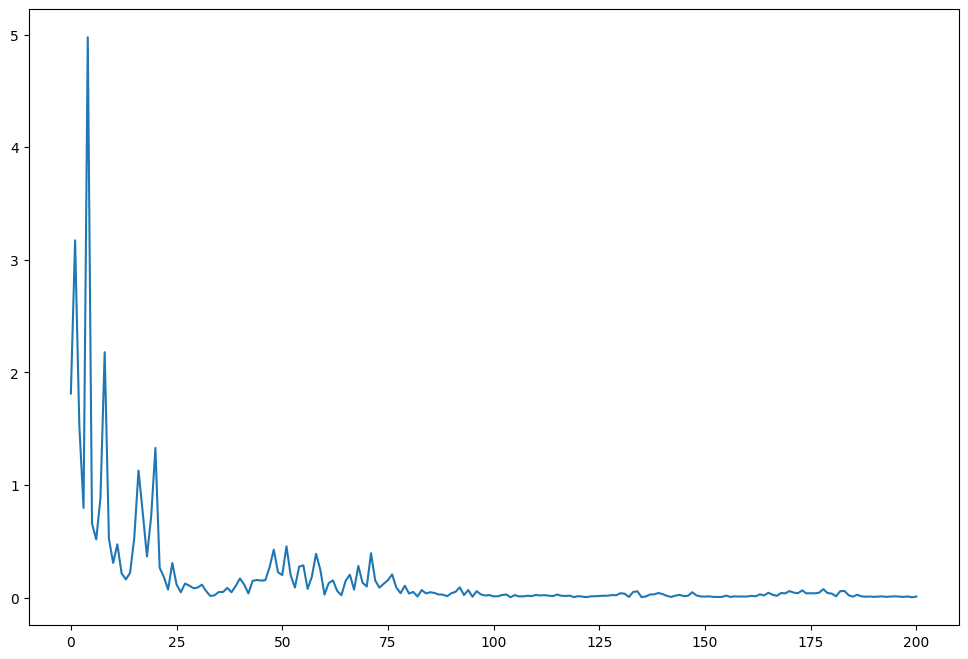

In [78]:
# look at power spectra
plt.figure(figsize=(12, 8))
plt.plot(power_spectra[0])

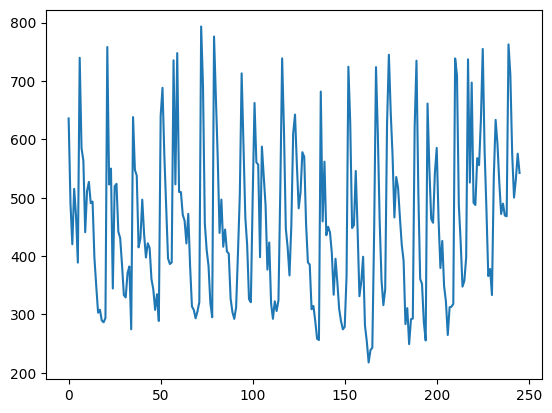

In [13]:
# plot total power
plt.plot(total_powers)

In [12]:
# strobe for one second
lights['strobe_intensity'].dim(255)
lights['strobe_speed'].dim(255) 
time.sleep(1)
lights['strobe_intensity'].dim(0)
lights['strobe_speed'].dim(0)

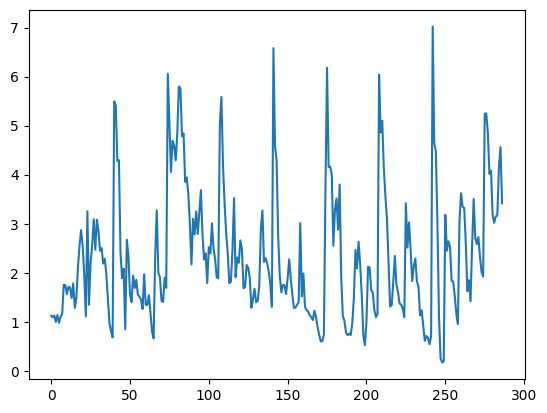

In [100]:
plt.plot(mids)

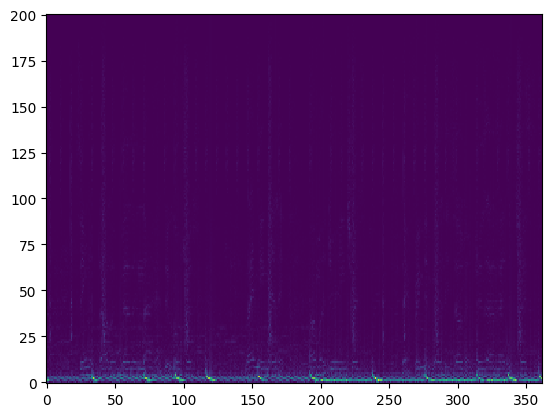

In [78]:
plt.imshow(np.array(power_spectra).T, aspect='auto', origin='lower', interpolation='none')

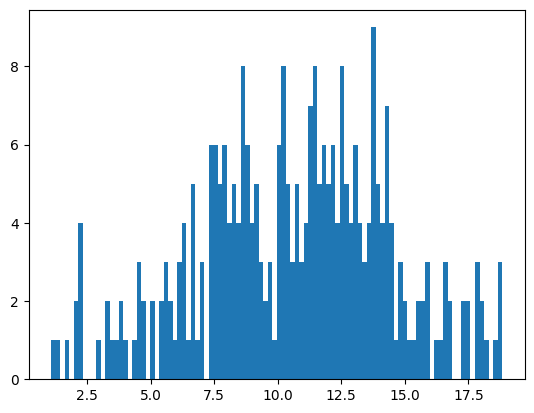

In [ ]:
plt.hist(np.array(testvals), bins=100);

In [ ]:
# make a spooky flicker effect
state = 'off'
while True:
    if state == 'off':
        val = 0
        state = 'on'
    else:
        val = 255
        state = 'off'
    time.sleep(1/36)
    #val = np.random.randint(100, 255)
    # alternate between off and on
    lights['1'].dim(val)

KeyboardInterrupt: 

In [ ]:
# make everything strobe for two seconds
lights['strobe_speed'].dim(255)
lights['strobe_intensity'].dim(10)
lights['rgb1'].set_channels([255, 0, 0, 255, 255, 0, 0])
lights['rgb2'].set_channels([255, 0, 255, 0, 255, 0, 0])
time.sleep(1)
# then turn it all off
lights['strobe_speed'].dim(0)
lights['strobe_intensity'].dim(0)
lights['rgb1'].set_channels([0, 0, 0, 0, 0, 0, 0])
lights['rgb2'].set_channels([0, 0, 0, 0, 0, 0, 0])

# then set all the other lights to blinking
for i in range(1, 5):
    lights[str(i)].dim(255)
    time.sleep(1)
    lights[str(i)].dim(0)
    time.sleep(0.1)

: 

In [ ]:
rgb = dmx.add_fixture(rgb_light)

NameError: name 'rgb_light' is not defined

In [ ]:
# set rgb to white
rgb.set_channels([255, 255, 255, 255, 0, 0, 0])

In [ ]:
# turn 1-4 on
lights['1'].dim(255)
lights['2'].dim(255)
lights['3'].dim(255)
lights['4'].dim(255)

In [ ]:
# turn 1-4 off
lights['1'].dim(128)
lights['2'].dim(0)
lights['3'].dim(0)
lights['4'].dim(0)

In [ ]:
lights['strobe_intensity'].dim(255)
lights['strobe_speed'].dim(255)
time.sleep(0.5)
lights['strobe_intensity'].dim(0)
lights['strobe_speed'].dim(0)

In [ ]:
# light up the RGB to white
lights['rgb'].set_channels([255, 255, 255, 255, 0, 0, 0])

/Users/f004swn/anaconda3/envs/spotify/lib/python3.12/site-packages/PyDMXControl/utils/timing/_Ticker.py:79: UserWarning: Ticker loop behind by 4.225179036458332ms, took 20.891845703125ms
  warn("Ticker loop behind by {:,}ms, took {:,}ms".format(-wait_dur, loop_dur))
/Users/f004swn/anaconda3/envs/spotify/lib/python3.12/site-packages/PyDMXControl/utils/timing/_Ticker.py:79: UserWarning: Ticker loop behind by 121.47639973958333ms, took 138.14306640625ms
  warn("Ticker loop behind by {:,}ms, took {:,}ms".format(-wait_dur, loop_dur))
